In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/lfw.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [4]:
path = '/content/lfw/'

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.cuda.is_available():
    # Check if MPS is available
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device.")
    else:
        device = torch.device("cuda")
        print("Using CUDA device.")
else:
    # If CUDA is not available, use CPU
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

Using CUDA device.


torch.Size([250, 250, 3])


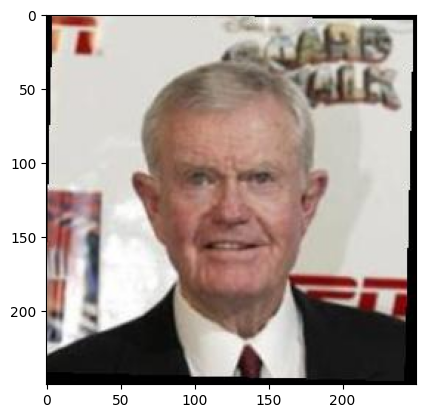

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Autoencoders (AEs) and Variational Autoencoders (VAEs) are both types of neural networks used for unsupervised learning of compressed representations for input data, typically for the task of data reconstruction. However, they differ significantly in terms of their applications, architecture, and loss functions.

**Applications:**

**Autoencoders (AEs):** They are mainly used for dimensionality reduction, denoising, and feature learning. Since they learn to compress data and then reconstruct it, they can be applied in areas like image compression where exact or near-exact reconstruction is important. They can also be used for anomaly detection because they will typically reconstruct normal data well but fail to do so for outliers.

**Variational Autoencoders (VAEs):** VAEs are used in generative modeling; they can generate new instances that are similar to the input data. This makes them suitable for tasks like image generation, where you want to create new images that resemble a training dataset. They are also used in semi-supervised learning, as they can learn useful representations that help in classification with limited labeled data.

**Architecture:**

**Autoencoders:** AEs have a simple architecture consisting of an encoder and a decoder. The encoder compresses the input into a lower-dimensional latent space, and the decoder reconstructs the input from this representation. The architecture is deterministic, meaning if you input the same data point multiple times, you will get the same encoded representation each time.

**Variational Autoencoders:** VAEs also consist of an encoder and a decoder. However, the encoder in a VAE maps inputs to a distribution in latent space rather than a single point. Specifically, it produces two things for each input: a mean and a variance that are used to define a probability distribution (typically Gaussian) from which a latent vector is sampled. The decoder then reconstructs the input from these sampled latent vectors. This stochasticity means that even the same data point can produce different encodings upon different passes through the network, allowing for the generation of new data points.

**Loss Function:**

**Autoencoders:** The loss function for AEs typically measures the difference between the input and its reconstruction, such as Mean Squared Error (MSE) or Binary Cross-Entropy, depending on the nature of the input data.

**Variational Autoencoders:** The loss function for VAEs has two components. The first is similar to that of AEs, measuring the reconstruction error. The second component is the Kullback-Leibler (KL) divergence, which measures how much the learned distribution in the latent space deviates from a prior distribution (usually a standard normal distribution). This encourages the encoder to produce latent representations that are regularized, preventing overfitting and ensuring that the model learns a continuous, smooth representation of the data.

Both AEs and VAEs are used for learning efficient representations of data, AEs tend to be used more for tasks that involve compression and reconstruction, whereas VAEs are favored for generative tasks. The introduction of a probability distribution in the latent space and the KL divergence in the loss function are the key features that distinguish VAEs from traditional AEs.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomVAE(nn.Module):
    def __init__(self):
        super(CustomVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self._to_linear = None
        self._calculate_flat_size((3, 250, 250))

        # Fully Connected Layers for Mean and Log Variance
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc21 = nn.Linear(1024, 20)
        self.fc22 = nn.Linear(1024, 20)

        # Decoder
        self.fc3 = nn.Linear(20, 1024)
        self.fc4 = nn.Linear(1024, 128 * 16 * 16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Sigmoid()
        )

    def _calculate_flat_size(self, shape):
        with torch.no_grad():
            x = torch.ones(1, *shape)
            x = self.encoder(x)
            self._to_linear = x.view(-1).shape[0]

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 128, 16, 16)
        z = self.decoder(z)
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae_model = CustomVAE()


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [100]:
model = CustomVAE().to(device)
# Fetch a batch of images from the data loader
images, _ = next(iter(dataloader))

# Select the first image from the batch for demonstration
image = images[0].unsqueeze(0)  # Add a batch dimension
print("input image:",image.shape)

# Pass the image through the VAE model
with torch.no_grad():
    mu, logvar = vae_model.encode(image)
    print(f"Shape of mu (mean): {mu.shape}")
    print(f"Shape of logvar (log variance): {logvar.shape}")

    # Generate a sample in the latent space and decode it
    z = vae_model.reparameterize(mu, logvar)
    reconstructed_img = vae_model.decode(z)
    print(f"Shape of reconstructed image: {reconstructed_img.shape}")


input image: torch.Size([1, 3, 250, 250])
Shape of mu (mean): torch.Size([1, 20])
Shape of logvar (log variance): torch.Size([1, 20])
Shape of reconstructed image: torch.Size([1, 3, 250, 250])


First, we instantiate the VAE model defined previously.
Processing an Image Through the VAE
Assuming we have an image tensor img that we want to pass through the model, we first ensure it has the correct shape (batch_size, channels, height, width).

**Encoder**
The encoder outputs two tensors: mu and logvar. These represent the parameters (mean and log variance) of the Gaussian distribution in the latent space from which we can sample new latent vectors.


**Generating New Samples in the Latent Space**

We generate new points in the latent space by adding a bit of randomness to our 'best guess' of where images like our input tend to be located.

Sampling Latent Vectors: We draw samples from the Gaussian distribution characterized by mu and logvar. The reparameterization trick is applied to sample eps from a standard normal distribution, then transforming it to have the same mean and variance as our latent distribution.

Decoding to Generate Images: The sampled latent vectors z are then passed through the decoder to reconstruct or generate new images.

**Decoder Output and Forward Pass Verification:**
The decoder's output, new_images, should have the same dimensions as the original input image. This confirms that the model's forward pass is correctly transforming the input data through the encoder to the latent space and back to the original data space through the decoder.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [101]:
total_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")


Total number of parameters: 93751019


Loss Function for VAE
The loss function for a VAE is composed of two distinct terms:

**Reconstruction Loss:**

This part of the loss function measures how well the VAE can reconstruct the input data after encoding and decoding it. It compares the original input with the output from the decoder. AS we are dealing with pixel values that are normalized between 0 and 1, we have used binary cross-entropy as the reconstruction loss.

**Goal of Reconstruction Loss:**

The reconstruction loss ensures that the VAE does not lose critical information during the encoding process. It essentially tells the model, "After all the encoding and decoding, our final output should look as close as possible to what you originally saw." This term encourages the model to learn to capture the important features of the data that are essential for a faithful reconstruction.

**Kullback-Leibler (KL) Divergence:**

This term measures how much the distribution of latent variables (defined by mu and logvar) diverges from a prior distribution, typically chosen to be the standard normal distribution. The KL divergence adds a penalty to the loss for deviating from this prior distribution.

**Goal of KL Divergence:**

The purpose of the KL divergence is to regularize the encoder by preventing it from encoding data points too specifically to certain areas in the latent space, which could lead to overfitting and poor generalization. By penalizing divergences from the standard normal distribution, it encourages the latent space to be well-organized and smooth, promoting the generation of plausible data even from points in the latent space that were not directly encoded from real data.

In [102]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Create the optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)


In [103]:
import torch
import torch.nn.functional as F

def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    beta = 1.0  # This is a hyperparameter to tune
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta*kl_div


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [111]:
# Instantiate the VAE model and move it to the device
vae_model = CustomVAE().to(device)

num_epochs = 10  # Set the number of epochs
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
# Training loop
for epoch in range(num_epochs):
    vae_model.train()  # Set the model to training mode
    total_loss = 0

    for batch_idx, (data, _) in enumerate(dataloader):
        # Move the data to the device (GPU or CPU)
        data = data.to(device)
        optimizer.zero_grad()
        # Forward pass: Compute the reconstruction and the latent space variables
        reconstructed, mu, logvar = vae_model(data)
        # Compute the loss
        loss = vae_loss_function(reconstructed, data, mu, logvar)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Print the average loss for the epoch
    average_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Average loss: {average_loss:.4f}")

Epoch [1/10] Average loss: 128680.6310
Epoch [2/10] Average loss: 126448.7765
Epoch [3/10] Average loss: 125854.4754
Epoch [4/10] Average loss: 125575.9067
Epoch [5/10] Average loss: 125317.7610
Epoch [6/10] Average loss: 125185.8097
Epoch [7/10] Average loss: 125078.3568
Epoch [8/10] Average loss: 124987.7532
Epoch [9/10] Average loss: 124904.5752
Epoch [10/10] Average loss: 124832.4991


If the loss isn't decreasing, several strategies can be employed to troubleshoot:

**Learning Rate Adjustment:** adjusting the learning rate can help if the optimizer is not converging.

**Model Architecture Review:** Reassessing the model complexity to ensure it fits the data well.

**Examine the Loss Function:** Making sure the loss function components are correct and appropriate for the data.

**Data Preprocessing:** Confirming the data is correctly preprocessed and normalized.

**Batch Size Variation:** Trying different batch sizes to see if it affects learning.

**Weight Initialization:** Changing the weight initialization strategy to improve training.

**Overfitting Check**: Implementing regularization techniques if the model is overfitting.

**Optimizer Choice:** Switching optimizers to find one that may perform better.

**KL Divergence Weight Tuning:** Adjusting the balance between reconstruction loss and KL divergence.
bold text
**Regularization:** Adding methods like dropout or batch normalization to improve training.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

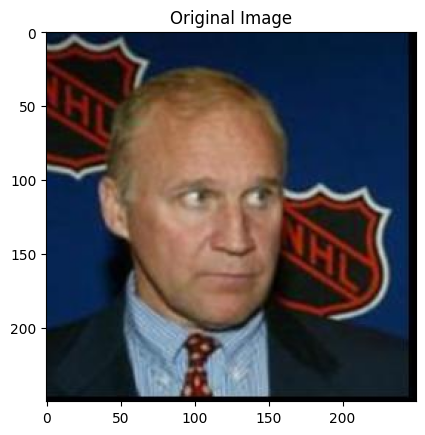

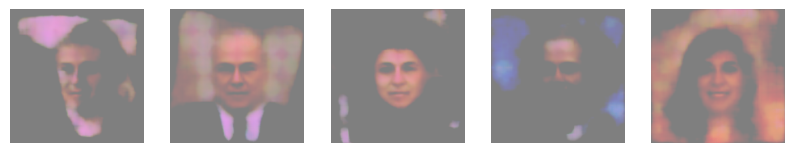

In [132]:
# After training
vae_model.eval()
# Take a random image from the dataset
with torch.no_grad():
    for i, (data, _) in enumerate(dataloader):
        if i == random.randint(0, len(dataloader)):
            original_image = data[0].to(device)
            plt.imshow(original_image.cpu().permute(1, 2, 0))
            plt.title("Original Image")
            plt.show()
            break
# Generating new samples and plot them
with torch.no_grad():
    sample = torch.randn(128, 20).to(device)
    generated_images = vae_model.decode(sample).cpu()
    # Plot the generated images
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 2))
    for ax, img in zip(axes.flat, generated_images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.show()